# Data ingestion notebook

This notebook includes scripts to download point-of-interest data from various sources. It can be ran manually and piece-by-piece to refresh the data sources as necessary.

## Data sought

We want a range of different data sources representing different locations of interest. Pulling these from the Google Places API is expensive, so we'll use free sources where possible.

We want to obtain the locations of the following:

- Cafes
- Restaurants
- Bars/Pubs
- Grocery stores
- Pharmacies
- Child care
- Aged care
- Hospitals
- Schools and universities
- Libraries
- Museums
- Galleries
- Parks
- Post offices
- Places of worship

We also want to combine this with census data at the LGA, POA, and suburb levels.

## Area of interest

We are focused on the general Melbourne urban area, represented by these LGAs:

- Banyule
- Bayside (Vic.)
- Boroondara
- Brimbank
- Darebin
- Glen Eira
- Greater Dandenong
- Hobsons Bay
- Hume
- Kingston (Vic.)
- Knox
- Manningham
- Maribyrnong
- Maroondah
- Melbourne
- Melton
- Monash
- Moonee Valley
- Moreland
- Nillumbik
- Port Phillip
- Stonnington
- Whitehorse
- Whittlesea
- Wyndham
- Yarra

This correlates roughly to a bounding box of:

```
N: -37.4
S: -38.1
E: 145.4
W: 144.4
```

In overlaying datasources we preference the GDA2020 projection over WGS84, but will convert as necessary.


## Data sources

### Vicmap Features - Features of Interest (FOI) Point

[Link](https://datashare.maps.vic.gov.au/search?md=019d7631-1234-5112-9f21-8f7346647b61)

Coverage:

- Places of worship
- Child care
- Aged care
- Hospitals
- Schools and universities
- Libraries
- Museums
- Galleries
- Parks

Free, provided as shapefile download. 

### Here Geocoding and Search API (`browse` endpoint)

[Link](https://www.here.com/docs/bundle/geocoding-and-search-api-v7-api-reference/page/index.html#/paths/~1browse/get)

Coverage:
- Cafes
- Restaurants
- Bars/Pubs
- Grocery Stores

Paid after 5,000 requests per month. REST API.

### Australia Post API (extra stretch goal)

[Link](https://auspost.com.au/developers/openapi/public/locations/operation/getGeoLocationsByPostCodeUsingGET/)

Can query all post points by post code area or distance from a co-ordinate pair.

Coverage:
- Post offices

Free with API key

### Pharmacy Guild (extra stretch goal)

[Link](https://www.findapharmacy.com.au/)

The Find a Pharmacy website queries an unsecured API backend to populate its map, which we can intercept for our own purposes.

Coverage:
- Pharmacies

Free

### Census 2021 datapacks

[Link](https://www.abs.gov.au/census/find-census-data/datapacks)

Provides direct data for given geographies in CSV. 

### Census geographies

[Link](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files)

Shapefiles for 2021 geographies (in GDA2020).

## Credentials
Refer to the `env.template` file and save as `.env` with credentials attached.

## Processing aims

Location data should be combined into a unified labelling schema in GDA2020, importable to a single geopandas geodataframe with point geometries. Labelling should indicate source and location type, i.e. each location should have:

- GDA2020 point geometry
- Name
- Category
- Source

Data is saved in `data/prepared/` as feather for downstream processing.



## Imports and set up

In [239]:
import geopandas as gpd
from shapely.geometry import Polygon
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from shapely.geometry import box
import numpy as np
import json
from src.utils import get_data_from_api, create_point_geometry


# get credentials

load_dotenv()
keys={
    'here': os.getenv('HERE_API_KEY'),
    'auspost': os.getenv('AUSPOST_API_KEY')
}


## Shapefile processing

Shapefiles downloaded from the ABS can be quite heavy, we'll pare them down for production.

In [64]:
# bounding box for filtering
n, s, e, w = -37.4, -38.1, 145.4, 144.4

bbox_polygon = Polygon([(w, n), (e, n), (e, s), (w, s), (w, n)])
bb_gdf = gpd.GeoDataFrame(index=[0], geometry=[bbox_polygon], crs="EPSG:7844") # GDA2020's EPSG code is 7844

bb_gdf.to_file("data/meta/area_of_interest_bounding_box.shp")

In [65]:
def read_shp(geography, year = 2021):
    filestr =f'data/shapefiles/{geography}_{year}_AUST_GDA2020_SHP/{geography}_{year}_AUST_GDA2020.shp'
    return gpd.read_file(filestr)

lga_shp = read_shp('LGA')
poa_shp = read_shp('POA')
sal_shp = read_shp('SAL')

print(len(lga_shp))

lga_shp.head()

566


,LGA_CODE21,LGA_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
0,10050,Albury,1,New South Wales,AUS,Australia,305.6386,http://linked.data.gov.au/dataset/asgsed3/LGA2...,1.321768,0.030560,"POLYGON ((146.86566 -36.07292, 146.86512 -36.0..."
1,10180,Armidale Regional,1,New South Wales,AUS,Australia,7809.4406,http://linked.data.gov.au/dataset/asgsed3/LGA2...,6.034583,0.732825,"POLYGON ((151.32425 -30.26922, 151.32419 -30.2..."
2,10250,Ballina,1,New South Wales,AUS,Australia,484.9692,http://linked.data.gov.au/dataset/asgsed3/LGA2...,1.511121,0.044843,"MULTIPOLYGON (((153.57106 -28.87381, 153.57106..."
3,10300,Balranald,1,New South Wales,AUS,Australia,21690.7493,http://linked.data.gov.au/dataset/asgsed3/LGA2...,11.489912,2.115528,"POLYGON ((143.00433 -33.78164, 143.01538 -33.7..."
4,10470,Bathurst Regional,1,New South Wales,AUS,Australia,3817.8645,http://linked.data.gov.au/dataset/asgsed3/LGA2...,5.395114,0.370149,"POLYGON ((149.91213 -33.39581, 149.91147 -33.3..."


<Axes: >

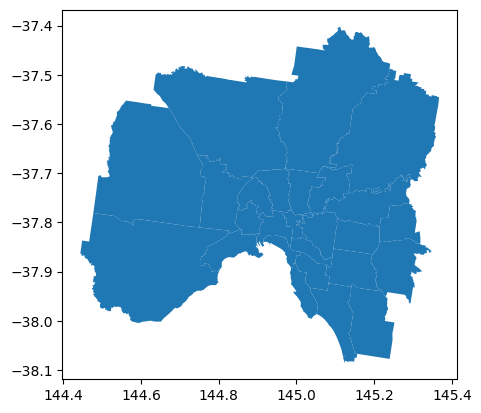

In [66]:
# use the bounding box to trim off extraneous shapes

lga_gdf = lga_shp[lga_shp.geometry.within(bb_gdf.geometry[0])]

lga_area_of_interest = lga_gdf.unary_union

lga_gdf.plot()

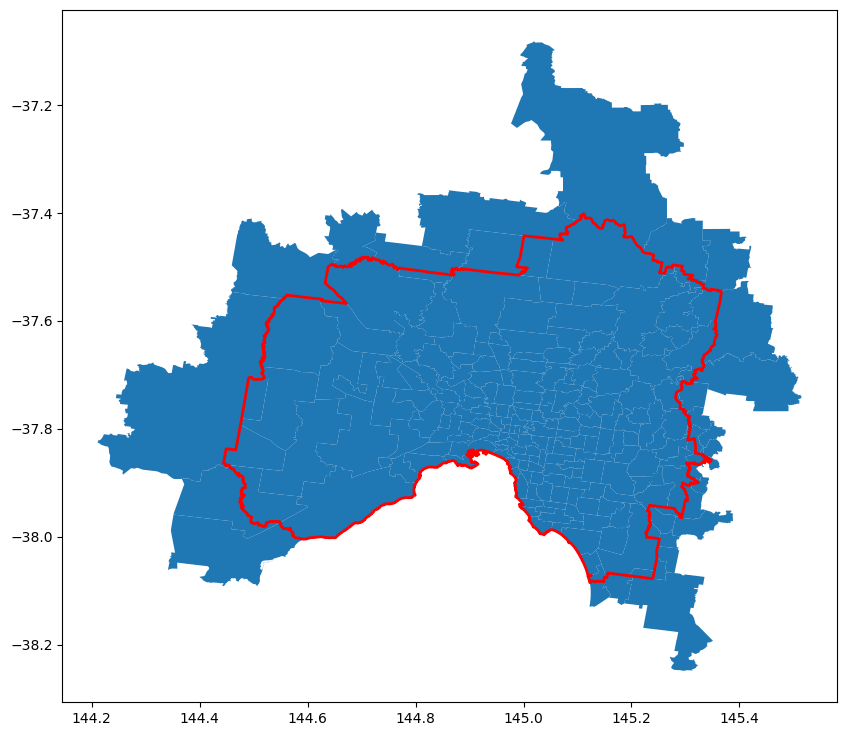

In [67]:
# For POA and SAL geographies, we're happy to take the intersection

sal_gdf = sal_shp[sal_shp.geometry.intersects(lga_area_of_interest)]
poa_gdf = poa_shp[poa_shp.geometry.intersects(lga_area_of_interest)]

ax = poa_gdf.plot(figsize=(10, 10))
gpd.GeoSeries([lga_area_of_interest]).plot(ax=ax, color='none', edgecolor='red', linewidth=2)

plt.show()

There are 1854 cells in total with a 1500m resolution


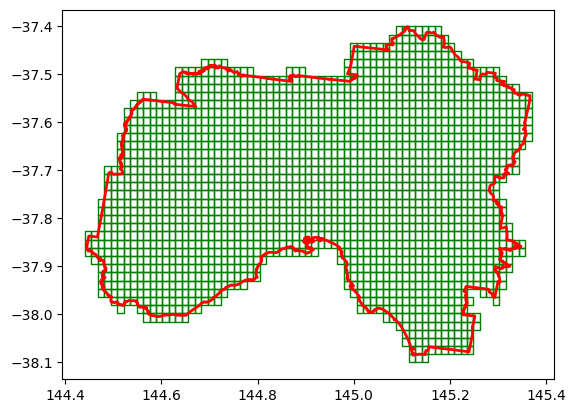

In [342]:

def km_to_deg(km, lat):
    km_per_degree_latitude = 111.32
    km_per_degree_longitude = 111.32 * np.cos(np.radians(lat))
    return km / km_per_degree_latitude, km / km_per_degree_longitude

def generate_tiled_gdf(bounding_box, resolution, crs="EPSG:7844"):
    minx, miny, maxx, maxy = bounding_box.bounds
    width_deg, height_deg = km_to_deg(resolution, (miny + maxy) / 2)
    
    rows = int(np.ceil((maxy - miny) / height_deg))
    cols = int(np.ceil((maxx - minx) / width_deg))
    
    squares = []
    for i in range(rows):
        for j in range(cols):
            bot_left_lat = miny + i * height_deg
            bot_left_lon = minx + j * width_deg
            square = box(bot_left_lon, bot_left_lat, 
                         bot_left_lon + width_deg, bot_left_lat + height_deg)
            squares.append(square)
    
    return gpd.GeoDataFrame(geometry=squares, crs=crs)

##### TWEAK THIS TO INFLUENCE THE NUMBER OF CELLS (AND THEREFORE API CALLS)
resolution_m = 1500
#####

grid_gdf = generate_tiled_gdf(bb_gdf.unary_union, resolution_m/1000)
grid_samples_gdf = grid_gdf[grid_gdf.geometry.intersects(lga_area_of_interest)] # filter it down

ax = grid_samples_gdf.plot(color='none', edgecolor='green', linewidth=1)
gpd.GeoSeries([lga_area_of_interest]).plot(ax=ax, color='none', edgecolor='red', linewidth=2)

print(f'There are {len(grid_samples_gdf)} cells in total with a {resolution_m}m resolution')

Noting that the City of Melbourne LGA has 2,123 restaurants in 2021 [per this data](https://data.melbourne.vic.gov.au/explore/dataset/cafes-and-restaurants-with-seating-capacity/information/) and an area of 37.5 square kilometers, which is a density of 56.6 restaurants per square kilometer. A one square km grid should hopefully be sufficient, assuming each call retrieves a max of 100 objects.

In [137]:
# save gdf objects to feather

lga_gdf[['LGA_CODE21','LGA_NAME21','AREASQKM21','geometry']].to_feather('data/prepared/lga.feather')
poa_gdf[['POA_CODE21','POA_NAME21','AREASQKM21','geometry']].to_feather('data/prepared/poa.feather')
sal_gdf[['SAL_CODE21','SAL_NAME21','AREASQKM21','geometry']].to_feather('data/prepared/sal.feather')
grid_gdf.to_feather(f'data/prepared/{resolution_m}mgrid.feather')


In [141]:
grid_gdf

,geometry
0,"POLYGON ((144.41347 -38.10000, 144.41347 -38.0..."
1,"POLYGON ((144.42695 -38.10000, 144.42695 -38.0..."
2,"POLYGON ((144.44042 -38.10000, 144.44042 -38.0..."
3,"POLYGON ((144.45390 -38.10000, 144.45390 -38.0..."
4,"POLYGON ((144.46737 -38.10000, 144.46737 -38.0..."
...,...
3145,"POLYGON ((145.35670 -37.40129, 145.35670 -37.3..."
3146,"POLYGON ((145.37018 -37.40129, 145.37018 -37.3..."
3147,"POLYGON ((145.38365 -37.40129, 145.38365 -37.3..."
3148,"POLYGON ((145.39713 -37.40129, 145.39713 -37.3..."


## Vicmap processing

Export and download the latest shapefile for the above co-ordinates in the GDA2020 projection. Use the area of interest bounding box shapefiles to filter down the export required. Copy the contents of `user_polygon-0` to the `data` folder as `vicmap-foi`.

In [185]:
vicmap_gdf = gpd.read_file('data/vicmap-foi/VMFEAT/FOI_POINT.shp')

# processing:
# - filter desired fields
# - map to desired columns (multipoint -> point geometries)

vicmap_labels = [
    'child care','aged care','entertainment centre','hall','community centre','senior citizens','art gallery','museum','library',
    'primary/secondary school','special school','primary school','tertiary institution','secondary school','university',
    'police station','ambulance station','fire station','maternal/child health centre','general hospital','day procedure centre',
    'tower','monument','tourist attraction','church','mosque','synagogue','rotunda','day visitor area','club house',
    'picnic site','playground','swimming pool'
]

cleaned_vicmap_gdf = (
    vicmap_gdf
    [vicmap_gdf['FEATSUBTYP'].isin(vicmap_labels)]
    [['FEATSUBTYP','NAME_LABEL','geometry']]
    .rename(columns = {'FEATSUBTYP': 'category', 'NAME_LABEL': 'name'})
)

def convert_multi_to_pt(geom):
    return geom.geoms[0] if geom.geom_type == 'MultiPoint' else geom

cleaned_vicmap_gdf['geometry'] = cleaned_vicmap_gdf['geometry'].apply(convert_multi_to_pt)

cleaned_vicmap_gdf['source'] = 'vicmap_foi'

cleaned_vicmap_gdf.to_feather('data/prepared/vicmap.feather')

cleaned_vicmap_gdf.head(5)


,category,name,geometry,source
0,secondary school,Elisabeth Murdoch College,POINT (145.19019 -38.15928),vicmap_foi
1,primary school,Frankston Heights Primary School,POINT (145.14718 -38.16179),vicmap_foi
2,secondary school,Koo Wee Rup Secondary College,POINT (145.49578 -38.19708),vicmap_foi
3,primary school,St Augustines School,POINT (145.14588 -38.17203),vicmap_foi
4,special school,Mount Erin Secondary College - Mount Erin Deaf...,POINT (145.14623 -38.17396),vicmap_foi


In [27]:
# location counts
cleaned_vicmap_gdf[['category','geometry']].groupby('category').count()

,geometry
category,
aged care,512
ambulance station,97
art gallery,31
child care,3523
church,602
club house,448
community centre,228
day procedure centre,95
day visitor area,64


## Here API processing

The Browse endpoints returns locations matching a category, within a specified area. We want these place categories:

- `100-1100` Coffee/Tea
- `100-1000` Dining
- `200-2000-0011` Bar/Pub
- `600-6300-0066` Grocery Store

In [242]:
def get_data_from_api(base_url, params, save_file=False, dry=False):
    unwrapped_params = {
        key: ','.join(map(str, value)) if isinstance(value, list) else value
        for key, value in params.items()
    }

    if dry:
        req = requests.Request('GET', base_url, params=unwrapped_params)
        prepared_req = req.prepare()
        return prepared_req.url

    response = requests.get(base_url, params=unwrapped_params)
    
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")
    data = response.json()

    if save_file:
        with open(save_file, 'w') as file:
            json.dump(data, file)


    return data

In [248]:
here_categories = ['100-1100','100-1000','200-2000-0011','600-6300-0066']
responses = []
empty_cell_index = []
downloaded_cell_index = []

In [276]:
print(empty_cell_index)
print(downloaded_cell_index)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 60, 61, 67, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 131, 132, 133, 134, 136, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 211, 212, 214, 218, 221, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 

In [275]:

import time

counter = 0

for index, row in grid_gdf.iterrows():

    if(index in empty_cell_index): continue
    if(index in downloaded_cell_index): continue

    centroid = row['geometry'].centroid
    minx, miny, maxx, maxy = row['geometry'].bounds

    params = {
        'apiKey': keys['here'],
        'categories': here_categories,
        'at':[centroid.y,centroid.x],
        'in':f"bbox:{minx},{miny},{maxx},{maxy}",
        'limit':100    
    }

    # print(get_data_from_api('https://browse.search.hereapi.com/v1/browse',params, dry=True))

    fname = f'data/rawjson/cell_{index}.json'
    response = get_data_from_api('https://browse.search.hereapi.com/v1/browse',params, save_file=fname)

    if len(response['items'])>0:
        responses.append(response)
        counter = counter+1
        downloaded_cell_index.append(index)
        print(f'Found data in cell {index} of {len(grid_gdf)}, downloaded this run: {counter}')
    else:
        empty_cell_index.append(index)

    time.sleep(1)

    # if counter>100: break




Found data in cell 512 of 3150, downloaded this run: 1
Found data in cell 513 of 3150, downloaded this run: 2
Found data in cell 517 of 3150, downloaded this run: 3
Found data in cell 518 of 3150, downloaded this run: 4
Found data in cell 532 of 3150, downloaded this run: 5
Found data in cell 546 of 3150, downloaded this run: 6
Found data in cell 547 of 3150, downloaded this run: 7
Found data in cell 570 of 3150, downloaded this run: 8
Found data in cell 571 of 3150, downloaded this run: 9
Found data in cell 572 of 3150, downloaded this run: 10
Found data in cell 573 of 3150, downloaded this run: 11
Found data in cell 574 of 3150, downloaded this run: 12
Found data in cell 575 of 3150, downloaded this run: 13
Found data in cell 576 of 3150, downloaded this run: 14
Found data in cell 577 of 3150, downloaded this run: 15
Found data in cell 578 of 3150, downloaded this run: 16
Found data in cell 580 of 3150, downloaded this run: 17
Found data in cell 581 of 3150, downloaded this run: 18
F

In [302]:
len(responses)

966

In [322]:
here_dfs = []
here_dfs_monitor = {
    'rows': 0,
    'id': 0,
    'name': 0,
    'position': 0,
    'access': 0,
    'categories': 0,
    'category': 0
}

def HEREAPI_data_to_df(data):

    records = []
    for x in data['items']:
        id = x.get('id')
        name = x.get('title')
        position = {'lat': x['position']['lat'], 'lng': x['position']['lng']}
        access = {'lat': x['access'][0]['lat'], 'lng': x['access'][0]['lng']}
        categories = [category['name'] for category in x.get('categories', []) if category.get('primary', False)]
        

        # Append the extracted data as a dictionary to the records list
        records.append({
            'id': id,
            'name': name,
            'position': position,
            'access': access,
            'categories': categories,
            'category': categories[0]
        })

        here_dfs_monitor['rows']+=1
        if name is not None: here_dfs_monitor['name']+=1
        if position is not None: here_dfs_monitor['position']+=1
        if access is not None: here_dfs_monitor['access']+=1
        if id is not None: here_dfs_monitor['id']+=1
        if categories[0] is not None: here_dfs_monitor['category']+=1
        

    here_df = pd.DataFrame(records)
    here_df['n_categories'] = here_df['categories'].apply(lambda x: len(x))
    here_df['coords_for_point'] = np.where(here_df['access'].notnull(), here_df['access'], here_df['position'])

    return here_df

for i in responses:
    here_dfs.append(HEREAPI_data_to_df(i))

here_df = pd.concat(here_dfs)

here_df.columns

Index(['id', 'name', 'position', 'access', 'categories', 'category',
       'n_categories', 'coords_for_point'],
      dtype='object')

In [323]:
here_dfs_monitor

{'rows': 16007,
 'id': 16007,
 'name': 16007,
 'position': 16007,
 'access': 16007,
 'categories': 0,
 'category': 16007}

In [336]:
here_df_prep = here_df.reset_index()[['id', 'name', 'category','coords_for_point']]
here_df_prep['geometry']=here_df_prep['coords_for_point'].apply(create_point_geometry)
here_df_prep['source']='here_api'
here_df_prep.drop(columns=['coords_for_point','id'], inplace = True) # we've checked no duplicate locations
here_gdf = gpd.GeoDataFrame(here_df_prep, geometry='geometry')
here_gdf.set_crs(epsg=7844, inplace=True)

,name,category,geometry,source
0,The Riviera Hotel,Bar or Pub,POINT (145.12504 -38.08875),here_api
1,Crackerjack Beachfront,Coffee Shop,POINT (145.12439 -38.08400),here_api
2,Coffee for the People Roasting Co.,Restaurant,POINT (145.13207 -38.09365),here_api
3,Bear and Cub,Fast Food,POINT (145.13207 -38.09365),here_api
4,Seaford Fish & Chippery,Fast Food,POINT (145.12831 -38.08918),here_api
...,...,...,...,...
16002,Gisborne Water Deliveries,Grocery,POINT (144.51823 -37.38434),here_api
16003,Mount Macedon Winery,Restaurant,POINT (144.55851 -37.38493),here_api
16004,Top of the Range Tea Rooms,Restaurant,POINT (144.57640 -37.38626),here_api
16005,Darraweit Valley Cider House,Restaurant,POINT (144.89113 -37.40016),here_api


<Axes: >

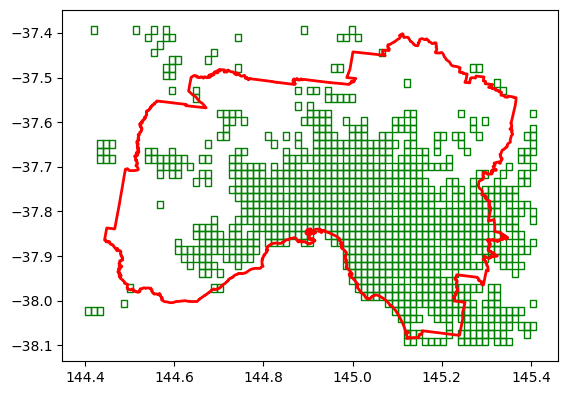

In [345]:
grid_gdf_of_interest = grid_gdf.iloc[downloaded_cell_index].reset_index()

grid_gdf_of_interest
grid_gdf_of_interest.to_feather('data/prepared/selected1000mgrid.feather')

ax = grid_gdf_of_interest.plot(color='none', edgecolor='green', linewidth=1)
gpd.GeoSeries([lga_area_of_interest]).plot(ax=ax, color='none', edgecolor='red', linewidth=2)

In [356]:
pd.set_option('display.max_rows', 100) 


desired_categories = ['Restaurant','Grocery','Cafeteria','Fast Food', 'Coffee Shop', 'Bar or Pub', 'Bakery & Baked Goods Store', 'Casual Dining', 'Hotel',
    'Nightlife-Entertainment','Food/Beverage Specialty Store','Tea House','Convenience Store','Sports Facility/Venue']

filtered_here_gdf = here_gdf[here_gdf.geometry.within(lga_area_of_interest)]

filtered_here_gdf = filtered_here_gdf[filtered_here_gdf['category'].isin(desired_categories)]

filtered_here_gdf


,name,category,geometry,source
82,Beach Bar Carrum,Restaurant,POINT (145.12200 -38.07422),here_api
83,Zanko,Restaurant,POINT (145.12225 -38.07536),here_api
84,Mr Smokestack Woodfire Pizza,Restaurant,POINT (145.12235 -38.07578),here_api
85,Carrum Beach Shack,Bar or Pub,POINT (145.12238 -38.07592),here_api
86,Wishing Well Tavern,Bar or Pub,POINT (145.12283 -38.07530),here_api
...,...,...,...,...
15879,Elisa's Family Bistro,Restaurant,POINT (145.11573 -37.51424),here_api
15880,McDonald's,Fast Food,POINT (145.11470 -37.51637),here_api
15881,Smokin Joe's,Restaurant,POINT (145.11436 -37.51794),here_api
15882,La Pizzoleria,Restaurant,POINT (145.11436 -37.51794),here_api


In [361]:
# only select ones in the area of interest, and save
filtered_here_gdf.to_feather('data/prepared/hereapi.feather')

In [367]:
# combine location geo data frames

combined_gdf = pd.concat([
    filtered_here_gdf,
    cleaned_vicmap_gdf
])

print(f'we have {filtered_here_gdf.shape[0]} records from the Here API and {cleaned_vicmap_gdf.shape[0]} from vic maps')

# checking preserved crs
combined_gdf.crs

we have 14560 records from the Here API and 12993 from vic maps


<Geographic 2D CRS: EPSG:7844>
Name: GDA2020
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia including Lord Howe Island, Macquarie Island, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore.
- bounds: (93.41, -60.55, 173.34, -8.47)
Datum: Geocentric Datum of Australia 2020
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [371]:
# write to feather/pickle

combined_gdf.to_feather('data/prepared/combined.feather')
combined_gdf.to_pickle('data/prepared/combined.pickle')


## Census processing